In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, losses, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, BatchNormalization, Conv2DTranspose, Reshape, Flatten, Dense, Input, Layer, MaxPooling2D
from tensorflow.keras import Model
import numpy as np

2025-05-22 16:24:06.665813: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 16:24:06.678287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747920246.694200   29555 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747920246.698898   29555 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747920246.711376   29555 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
class Sampling(Layer):
    def __init__(self, latent_dim=64):
        super(Sampling, self).__init__()
        self.latent_dim = latent_dim
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = tf.random.normal(shape=(tf.shape(mu)[0], self.latent_dim))
        return mu + tf.exp(0.5 * log_var) * epsilon
        # return mu + tf.sqrt(abs(log_var)) * epsilon

class VAE(Model):
    def __init__(self, latent_dim=64, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()
        self.mse = losses.MeanSquaredError()
        # self.reconstruction_loss = losses.BinaryCrossentropy()

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.mu_mean_tracker = tf.keras.metrics.Mean(name="mu_mean")
        self.log_var_mean_tracker = tf.keras.metrics.Mean(name="log_var_mean")

    def _build_encoder(self):
        encoder_inputs = Input(shape=(32, 32, 3))
        x = Conv2D(32, 3, padding="same", activation="relu")(encoder_inputs)
        x = BatchNormalization()(x)
        x = MaxPooling2D()(x)
        
        x = Conv2D(64, 3, padding="same", activation="relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D()(x)
        
        x = Conv2D(128, 3, padding="same", activation="relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D()(x)
        
        x = Flatten()(x)
        x = Dense(256)(x)
        mu = Dense(self.latent_dim)(x)
        log_var = Dense(self.latent_dim)(x)
        z = Sampling()([mu, log_var])
        return Model(encoder_inputs, [mu, log_var, z], name="encoder")

    def _build_decoder(self):
        latent_inputs = Input(shape=(self.latent_dim,))
        x = Dense(4*4*128, activation="relu")(latent_inputs)
        x = Reshape((4, 4, 128))(x)
        x = Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
        x = BatchNormalization()(x)
        
        x = Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
        x = BatchNormalization()(x)
        
        x = Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
        x = BatchNormalization()(x)
        
        decoder_outputs = Conv2DTranspose(3, 3, padding="same", activation="tanh")(x)
        return Model(latent_inputs, decoder_outputs, name="decoder")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def loss_func(self, expect, result, mu, log_var, betta = 1.0):
      mse_value = self.mse(expect, result)
      KL_distance =  tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var)), axis=1))
      return mse_value + betta * KL_distance, mse_value, KL_distance

    def train_step(self, data):
      noisy_images, original_images = data

      with tf.GradientTape() as tape:
          mu, log_var, z = self.encoder(noisy_images)
          # print(mu, log_var, z)
          reconstruction = self.decoder(z)
          # log_var = tf.clip_by_value(log_var, -10, 10)
          # print(noisy_images, original_images, reconstruction)
          total_loss, mse_value, kl_distance = self.loss_func(original_images, reconstruction, mu, log_var, betta=0.1)

      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(mse_value)
      self.kl_loss_tracker.update_state(kl_distance)
      self.mu_mean_tracker.update_state(tf.reduce_mean(mu))
      self.log_var_mean_tracker.update_state(tf.reduce_mean(log_var))

      return {
          "loss": self.total_loss_tracker.result(),
          "reconstruction_loss": self.reconstruction_loss_tracker.result(),
          "kl_loss": self.kl_loss_tracker.result(),
          "mu_mean": self.mu_mean_tracker.result(),
          "log_var_mean": self.log_var_mean_tracker.result(),
      }

    def call(self, inputs):
        mu, log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

In [ ]:
vae = VAE(latent_dim=64)
vae.compile(optimizer=Adam(learning_rate=1e-4))

x_train_new = (x_train.astype('float32') - 128.0) / 128.0
# x_test_new = x_test.astype('float32') / 255.0
# x_train_new = x_train

noise_factor = 0.01
x_train_noisy = x_train_new + noise_factor * tf.random.normal(shape=x_train_new.shape)
x_train_noisy = tf.clip_by_value(x_train_noisy, -1.0, 1.0)

history = vae.fit(
    x_train_noisy, x_train_new,
    # validation_data=(x_test_noisy, x_test),
    epochs=10,
    batch_size=64
)

I0000 00:00:1747920268.285230   29555 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2156 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/10


I0000 00:00:1747920274.061473   29718 service.cc:152] XLA service 0x7bd0a401fa00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747920274.061491   29718 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-05-22 16:24:34.142189: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747920274.683747   29718 cuda_dnn.cc:529] Loaded cuDNN version 90300


 15/782 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - kl_loss: 0.6454 - log_var_mean: -2.4981e-04 - loss: 0.3147 - mu_mean: -0.0213 - reconstruction_loss: 0.2502

I0000 00:00:1747920281.470426   29718 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - kl_loss: 0.0593 - log_var_mean: -1.9527e-04 - loss: 0.2541 - mu_mean: -6.3124e-04 - reconstruction_loss: 0.2481
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - kl_loss: 6.6801e-04 - log_var_mean: -1.8649e-04 - loss: 0.2467 - mu_mean: -2.5759e-05 - reconstruction_loss: 0.2467
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - kl_loss: 8.8034e-04 - log_var_mean: -1.4382e-04 - loss: 0.2466 - mu_mean: -1.6831e-05 - reconstruction_loss: 0.2466
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - kl_loss: 8.5069e-04 - log_var_mean: -1.1919e-04 - loss: 0.2462 - mu_mean: -1.2328e-05 - reconstruction_loss: 0.2461
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - kl_loss: 7.5822e-04 - log_var_mean: -1.0309e-04 - loss: 0.2461 - mu_mean: -9.7936e-06 - reconstruction_loss: 0.2460
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - kl_loss: 7.1124e-04 - log_var_mean: -9.1453e-05 - loss: 0.2468 - mu_mean: -8.7289e-06 - reconstruction

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9921875].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20259595..0.2270585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9609375..0.984375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18439911..0.20380877].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84375..0.9921875].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20973276..0.12539667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96875..0.8

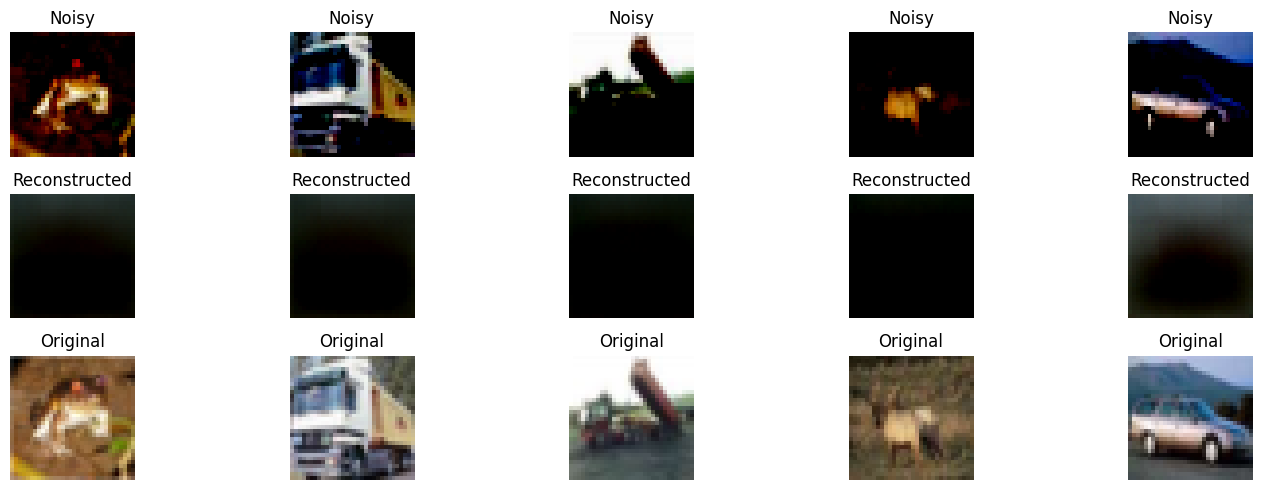

In [5]:
num_examples = 5
test_samples = x_train_new[:num_examples]

# Реконструируем
reconstructions = vae.predict(test_samples)

# Отображение
plt.figure(figsize=(15, 5))
for i in range(num_examples):
    # Зашифрованное изображение
    plt.subplot(3, num_examples, i + 1)
    plt.imshow(test_samples[i])
    plt.title("Noisy")
    plt.axis("off")

    # Реконструкция
    plt.subplot(3, num_examples, num_examples + i + 1)
    plt.imshow(reconstructions[i])
    plt.title("Reconstructed")
    plt.axis("off")

    # Оригинал
    plt.subplot(3, num_examples, 2*num_examples + i + 1)
    plt.imshow(x_train[i])
    plt.title("Original")
    plt.axis("off")

plt.tight_layout()
plt.show()